# Notebook: Use NN to predict disease from chemicals using Opa2Vec vectors
<b> Author: </b> Ian Coleman <br>
<b> Purpose: </b> Take the vectors created in the opa2vec notebook. This took chemical go functions
    and disease go function, creating vectors for each. Train a NN to predict positive chem-dis relationships from these vectors

In [2]:
## TODO
# Hyperparameter tuning:
# 1. How many uncorrelated pairs do we want
# 2. Epochs
# 3. Batch size
# 4. Number of layers, number of nodes per layer
# 5. Activation functions

In [3]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from random import randint
import random
from sklearn.model_selection import train_test_split
import sklearn
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from pandas_ml import ConfusionMatrix
import json
import subprocess

#Set random seed
np.random.seed(1606)

### 1. Import Vectors and Pre-Process them

In [4]:
# Import vec file
with open('AllVectorResults.lst', 'r') as file:
    text = file.read()

In [5]:
# Strip and split vector data into list of lists [chem, vec]
text = text.replace('\n', '')
text = text.split(']')
text = [item.strip().split(' [') for item in text]

# Turn it into a data frame
df = pd.DataFrame(text)
df.columns = ['ID', 'Vector']

# Clean
df = df.dropna()
df['Vector'] = df.Vector.map(lambda x: x.rstrip().lstrip().replace('    ', ' ').replace('   ', ' ').replace('  ', ' ').replace(' ', ','))

# Turn vector column into a list
df['Vector'] = df.Vector.map(lambda x: x.split(','))

In [6]:
df.head()

,ID,Vector
0,MESH:D012559,"[0.01491615, -0.00155747, -0.30986652, 0.04035..."
1,MESH:D009404,"[3.82804424e-02, 1.29408345e-01, 3.75053808e-0..."
2,MESH:D001749,"[-0.01025235, 0.00664143, -0.30367315, 0.15593..."
3,MESH:D011471,"[-0.0130785, -0.02445601, -0.46697775, 0.13181..."
4,MESH:D008106,"[-0.06240484, 0.00166245, -0.5013923, 0.116841..."


### 2. Create DF for NN
Munge the df into the following columns:<br>
ChemID DisID ChemVec DisVec PositiveAssociationExists(binary)

In [7]:
# Step 1: Import file of proven chem-dis positive associations (created in ctd-to-nt notebook from ctd data)
chem_dis = pd.read_csv('../ctd-to-nt/chem-dis-pos-assocs.csv')
chem_dis.head()

,ChemicalID,DiseaseID
0,C112297,MESH:D006948
1,C112297,MESH:D012640
2,C425777,MESH:D006948
3,C013567,MESH:D006333
4,C418863,MESH:D013262


In [8]:
# Get rid of any chems/diseases that don't have a vector
chem_dis['DiseaseID'] = chem_dis['DiseaseID'].astype(str)
df['ID'] = df['ID'].astype(str)
id_list = df.ID.tolist() # list of chems+diseases with vecs

chem_dis['hasDVec'] = chem_dis.DiseaseID.map(lambda x: x in id_list)
chem_dis['hasCVec'] = chem_dis.ChemicalID.map(lambda x: x in id_list)
chem_dis = chem_dis.loc[(chem_dis['hasDVec'] == True) & (chem_dis['hasCVec'] == True)]
chem_dis = chem_dis.drop(['hasDVec','hasCVec'], axis=1)

In [9]:
# merge all info into one df
# this df now contains only correlated diseases and vecs
df_d = df.copy()
df_d.columns= ['DiseaseID', 'DVec']
df_c = df.copy()
df_c.columns= ['ChemicalID', 'CVec']
df1 = pd.merge(chem_dis, df_d, on='DiseaseID')
df1 = pd.merge(df1, df_c, on='ChemicalID')

df1['Correlation'] = 1 # currently only have correlated in there

In [10]:
# Create separate dfs of dis-vecs and chem-vecs ( in order to generate additional rows for df1)
dis = df.ID.map(lambda x: ('MESH' in x) | ('OMIM' in x))
chems = df.ID.map(lambda x: ('MESH' not in x) & ('OMIM' not in x))

df_chems = df[chems]
df_dis = df[dis]
df_chems = df_chems.reset_index(drop=True)
df_dis = df_dis.reset_index(drop=True)

In [11]:
# Add unrelated pairs to df1
no_rows = (df1.shape[0]-1)  # This is a parameter to be tuned --> how many uncorrelated pairs do we want
print('shape: ', no_rows)

# Randomly select chems and diseases (as many as there are related pairs)
no_chems = len(df_chems) -1
no_dis = len(df_dis) -1
rand_chems = np.random.choice(no_chems, no_rows, replace=True)
rand_dis = np.random.choice(no_dis, no_rows, replace=True)

# Add the new pairs as rows
for x in range(0, no_rows):
    int1 = rand_chems[x]
    int2 = rand_dis[x]
    chem, chemvec = df_chems.loc[int1, 'ID'], df_chems.loc[int1, 'Vector']
    dis, disvec = df_dis.loc[int2, 'ID'], df_dis.loc[int2, 'Vector']
    df1 = df1.append({'ChemicalID':chem, 'DiseaseID':dis, 'CVec':chemvec, 'DVec':disvec, 'Correlation':0}, ignore_index=True)

print(df1.shape)
# Drop any duplicates (removes known correlated pairs accidentally generated as uncorrelated)
df1 = df1.drop_duplicates(subset=['ChemicalID', 'DiseaseID'], keep=False)
print(df1.shape)

shape:  6659
(13319, 5)
(13175, 5)


In [12]:
# Convert the elements of the vectors to actual numbers
df1['DVec'] = df1.DVec.map(lambda x: [float(i) for i in x])
df1['CVec'] = df1.CVec.map(lambda x: [float(i) for i in x])

### 2. Preprocess
Now that we have the df ready, let's split it into train/test/validation sets and convert it into numpy arrays so it can be consumed by a Keras NN

In [13]:
df1.head()

,ChemicalID,DiseaseID,DVec,CVec,Correlation
0,C049584,MESH:D001943,"[-0.00754089653, 0.0284954235, -0.145941272, -...","[0.02189679, 0.10079688, 0.04159389, -0.099326...",1
1,C049584,MESH:D018270,"[0.01976116, 0.098279193, 0.0369541571, -0.089...","[0.02189679, 0.10079688, 0.04159389, -0.099326...",1
2,C049584,MESH:D019457,"[0.03360923, 0.10056757, 0.05314376, -0.113913...","[0.02189679, 0.10079688, 0.04159389, -0.099326...",1
3,C049584,MESH:D003110,"[0.00136586, 0.13832065, 0.02338981, -0.113038...","[0.02189679, 0.10079688, 0.04159389, -0.099326...",1
4,C049584,MESH:D015179,"[-0.02237691, 0.07948194, -0.09784327, -0.0321...","[0.02189679, 0.10079688, 0.04159389, -0.099326...",1


In [14]:
# For Keras, need to turn inputs into numpy arrays instead of pandas df
# First create single np array of the two vectors CONCERN: should these be two separate inputs?
Dvecs = pd.DataFrame(df1.DVec.values.tolist(), index= df1.index)
Cvecs = pd.DataFrame(df1.CVec.values.tolist(), index= df1.index)
all_X = Dvecs.merge(Cvecs, how='outer', left_index=True, right_index=True)
all_X = np.array(all_X)

In [15]:
# Now create np array of the y output
all_y = np.array(df1.Correlation)

In [16]:
print('y shape: ', all_y.shape)
print('X shape: ', all_X.shape)

y shape:  (13175,)
X shape:  (13175, 400)


In [17]:
# # Create training, test, val set in a way that we can later look at the rows of each BY ROWS
# total_rows = len(all_X)
# row_numbers = list(range(0, total_rows))

# training_rows = random.sample(row_numbers, int(round(total_rows * .6)))
# row_numbers = set(row_numbers) - set(training_rows)

# test_rows = random.sample(row_numbers, int(round(total_rows * .2)))
# row_numbers = set(row_numbers) - set(test_rows)

# val_rows = list(row_numbers)

In [18]:
# Split into train, test, val BY CHEMICAL instead of by random rows
print('number of chemicals: ', len(df1.ChemicalID.unique()))
print('number of dis: ', len(df1.DiseaseID.unique()))
chems = list(df1.ChemicalID.unique())
random.shuffle(chems)

total_chems = len(chems)
train_chems = chems[:round(total_chems * .6)]
test_chems = chems[round(total_chems * .6):round(total_chems * .8)]
val_chems = chems[round(total_chems * .8):]

print(len(train_chems), len(test_chems), len(val_chems))

# Now get the row numbers for each set of chemicals 

number of chemicals:  412
number of dis:  2414
247 83 82


In [19]:
df1['train'] = df1.ChemicalID.isin(train_chems)
df1['test'] = df1.ChemicalID.isin(test_chems)
df1['val'] = df1.ChemicalID.isin(val_chems)

In [20]:
df1 = df1.reset_index()
training_rows = df1.index[df1.train == True].tolist()
test_rows = df1.index[df1.test == True].tolist()
val_rows = df1.index[df1.val == True].tolist()

In [21]:
# Split into train, test, val
X_train, X_test, X_val = all_X[training_rows], all_X[test_rows], all_X[val_rows]
y_train, y_test, y_val = all_y[training_rows], all_y[test_rows], all_y[val_rows]

print(len(training_rows), len(test_rows), len(val_rows))

7906 2773 2496


In [22]:
# # Split into train, test, val --> OLD WAY
# X_train, X_test, y_train, y_test = train_test_split(all_X, all_y, test_size=0.2, random_state=1606)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1606)

### 3. Establish NN Model

In [23]:
# 1. Establish the model architecture
#it's safe to say that I don't know what I'm doing here
model = keras.Sequential([
#     keras.layers.Dense(400, activation=tf.nn.relu), 
    keras.layers.Dense(200, activation=tf.nn.relu),
    keras.layers.Dropout(rate=0.2, noise_shape=None, seed=None),
    keras.layers.Dense(10, activation=tf.nn.relu),
    keras.layers.Dropout(rate=0.2, noise_shape=None, seed=None),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

In [24]:
# 2. Compile the model (give it loss func, optimise func and eval metric)
model.compile(optimizer=tf.train.AdamOptimizer(), # determines how the model is adapted based on loss func
              loss='binary_crossentropy', # measure of accuracy during training
              metrics=['accuracy']) # measure for train and testing steps 

In [25]:
# Pre-training, set up training params
earlystop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto', baseline=None)

In [26]:
# 3. Train
model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val) ) #, callbacks=[earlystop])

Train on 7906 samples, validate on 2496 samples
Epoch 1/10
7906/7906 [==============================] - 2s 250us/step - loss: 0.5584 - acc: 0.7251 - val_loss: 0.5542 - val_acc: 0.7364
Epoch 2/10
7906/7906 [==============================] - 2s 232us/step - loss: 0.5323 - acc: 0.7406 - val_loss: 0.5537 - val_acc: 0.7260
Epoch 3/10
7906/7906 [==============================] - 2s 230us/step - loss: 0.5191 - acc: 0.7531 - val_loss: 0.5535 - val_acc: 0.7284
Epoch 4/10
7906/7906 [==============================] - 2s 225us/step - loss: 0.5025 - acc: 0.7640 - val_loss: 0.5770 - val_acc: 0.7171
Epoch 5/10
7906/7906 [==============================] - 2s 226us/step - loss: 0.4890 - acc: 0.7700 - val_loss: 0.5660 - val_acc: 0.7268
Epoch 6/10
7906/7906 [==============================] - 2s 225us/step - loss: 0.4784 - acc: 0.7780 - val_loss: 0.5487 - val_acc: 0.7380
Epoch 7/10
7906/7906 [==============================] - 2s 221us/step - loss: 0.4702 - acc: 0.7823 - val_loss: 0.5452 - val_acc: 0.7404


### ...and evaluate

In [27]:
# 4. Evaluate
# Accuracy
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

2773/2773 [==============================] - 0s 84us/step
Test accuracy: 0.6992426974933327


In [28]:
# Get actual predictions for test set
predictions = model.predict(X_test)
rounded_predictions = [int(float(round(x[0]))) for x in predictions]

Confusion matrix:
Predicted  False  True  __all__
Actual                         
False        614   722     1336
True         112  1325     1437
__all__      726  2047     2773


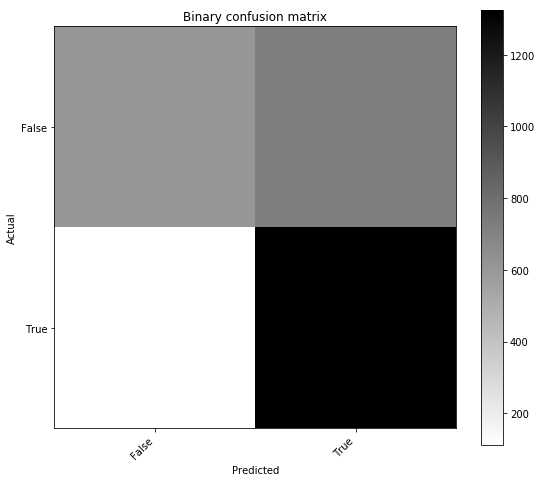

In [29]:
%matplotlib inline
# Confusion Matrix

confusion_matrix = ConfusionMatrix(y_test, rounded_predictions)
print("Confusion matrix:\n%s" % confusion_matrix)
confusion_matrix.plot()

In [30]:
# ROC AUC
print('ROC AUC: ', roc_auc_score(y_test, predictions))

ROC AUC:  0.8287673088061872


### 4. Examine the predictions
Let's look at the predictions the NN gets wrong, see if there's a pattern

In [31]:
# Create df with the relevant data
test_set = df1.loc[test_rows]
test_set['Predictions'] = predictions
test_set['RoundPredictions'] = rounded_predictions

In [32]:
# Optimise memory --> set col types for the incoming CSV
cds_cols = ['# ChemicalName', 'ChemicalID', 'DiseaseName', 'DiseaseID', 'DirectEvidence']
cd_col_types = {   
    '# ChemicalName': 'category',
    'ChemicalID': 'category',
    'DiseaseName': 'category',
    'DiseaseID': 'category',
}

In [49]:
# Let's get the disease and chemical names back! For the sake of eyeballing for patterns
# Read in CTD csv, skipping the intro rows
df_cd = pd.read_csv('../ctd-to-nt/csvs/CTD_chemicals_diseases.csv', usecols=cds_cols, dtype=cd_col_types, skiprows=27)
df_cd = df_cd.drop(0)
df_cd = df_cd.dropna(subset=['DirectEvidence']) # drop if it doesn't have direct evidence

In [34]:
df_cd.head()

,# ChemicalName,ChemicalID,DiseaseName,DiseaseID,DirectEvidence
1,06-Paris-LA-66 protocol,C046983,Precursor Cell Lymphoblastic Leukemia-Lymphoma,MESH:D054198,therapeutic
71,"10,10-bis(4-pyridinylmethyl)-9(10H)-anthracenone",C112297,Hyperkinesis,MESH:D006948,marker/mechanism
86,"10,10-bis(4-pyridinylmethyl)-9(10H)-anthracenone",C112297,Seizures,MESH:D012640,marker/mechanism
135,"10,11-dihydro-10-hydroxycarbamazepine",C039775,Epilepsy,MESH:D004827,therapeutic
189,"10,11-dihydroxy-N-n-propylnorapomorphine",C425777,Hyperkinesis,MESH:D006948,marker/mechanism


In [35]:
test_set.head()

,index,ChemicalID,DiseaseID,DVec,CVec,Correlation,train,test,val,Predictions,RoundPredictions
402,406,D003561,MESH:D001943,"[-0.00754089653, 0.0284954235, -0.145941272, -...","[0.01550489, 0.10461956, 0.03589396, -0.080799...",1,False,True,False,0.917976,1
403,407,D003561,MESH:D019457,"[0.03360923, 0.10056757, 0.05314376, -0.113913...","[0.01550489, 0.10461956, 0.03589396, -0.080799...",1,False,True,False,0.808121,1
404,408,D003561,MESH:D000740,"[0.02901717, 0.0821704, 0.0358058, -0.09371509...","[0.01550489, 0.10461956, 0.03589396, -0.080799...",1,False,True,False,0.329774,0
405,409,D003561,MESH:D001259,"[0.0383093692, 0.131072834, 0.057939373, -0.12...","[0.01550489, 0.10461956, 0.03589396, -0.080799...",1,False,True,False,0.861303,1
406,410,D003561,MESH:D056486,"[0.00546956, 0.06969541, -0.16318376, -0.01038...","[0.01550489, 0.10461956, 0.03589396, -0.080799...",1,False,True,False,0.931571,1


In [36]:
# test_set.DiseaseID.nunique()

In [37]:
def mem_usage(pandas_obj):
    if isinstance(pandas_obj,pd.DataFrame):
        usage_b = pandas_obj.memory_usage(deep=True).sum()
    else: # we assume if not a df it's a series
        usage_b = pandas_obj.memory_usage(deep=True)
    usage_mb = usage_b / 1024 ** 2 # convert bytes to megabytes
    return "{:03.2f} MB".format(usage_mb)

In [38]:
test_set['Correlation'] = test_set.Correlation.astype(np.uint8)
print(mem_usage(test_set['RoundPredictions']))
test_set['RoundPredictions'] = test_set.RoundPredictions.astype(np.uint8)
print(mem_usage(test_set['RoundPredictions']))

0.04 MB
0.02 MB


In [58]:
lst = [chem_dis, df, df_d, df_c, Dvecs, Cvecs]
del lst
test_set = test_set.drop(['DVec', 'CVec', 'index'], axis=1) # memory intensive
for col in ['DiseaseID', 'ChemicalID', 'DiseaseName', '# ChemicalName', 'DirectEvidence']:
    print(col,  df_cd.columns)
    if str(col) in df_cd.columns: print('sd') # df_cd[col] = df_cd[col].astype('category')
    if col in test_set.columns: test_set[col] = test_set[col].astype('category')

DiseaseID Index(['# ChemicalName', 'ChemicalID', 'DiseaseName', 'DiseaseID'], dtype='object')
sd
ChemicalID Index(['# ChemicalName', 'ChemicalID', 'DiseaseName', 'DiseaseID'], dtype='object')
sd
DiseaseName Index(['# ChemicalName', 'ChemicalID', 'DiseaseName', 'DiseaseID'], dtype='object')
sd
# ChemicalName Index(['# ChemicalName', 'ChemicalID', 'DiseaseName', 'DiseaseID'], dtype='object')
sd
DirectEvidence Index(['# ChemicalName', 'ChemicalID', 'DiseaseName', 'DiseaseID'], dtype='object')


In [59]:
mem_usage(df_cd)

'6.51 MB'

In [ ]:
# merge in the names

# Because this weirdly requires a tonne of memory, let's optimise (for stupid terrible top-of-range dell laptop)
# lst = [chem_dis, df, df_d, df_c, Dvecs, Cvecs]
# del lst
# test_set = test_set.drop(['DVec', 'CVec', 'index'], axis=1) # memory intensive
# for col in ['DiseaseID', 'ChemicalID', 'DiseaseName', '# ChemicalName', 'DirectEvidence']:
#     if col in df_cd.columns: df_cd[col] = df_cd[col].astype('category')
#     if col in test_set.columns: test_set[col] = test_set[col].astype('category')

test_set = pd.merge(test_set, df_cd[['DiseaseID', 'DiseaseName']], on='DiseaseID')
test_set = pd.merge(test_set, df_cd[['# ChemicalName', 'ChemicalID']], on='ChemicalID')

# weirdly these operations introduce millions of duplicate rows, so delete duplicates:
test_set = test_set.drop_duplicates(list(set(test_set.columns.values))) #- set(['DVec','CVec'])))

In [62]:
df_cd.ChemicalID = df_cd.ChemicalID.astype('category')
type(df_cd.ChemicalID[1])

str

In [ ]:
test_set[['DiseaseName', '# ChemicalName', 'Correlation', 'Predictions', 'RoundPredictions']].to_csv('predictions.csv', index=False)

In [ ]:
test_set.head()

In [ ]:
# Import gofunction counts (for each disease and each chem). This csv was output in opa2vec.ipynb
gofunc_counts = pd.read_csv('gofunc_counts.csv')
test_set = pd.merge(test_set, gofunc_counts[['ChemicalID', 'gofunc']], on='ChemicalID')
test_set = test_set.rename(columns = {'gofunc':'ChemGoFuncs'})
test_set = pd.merge(test_set, gofunc_counts[['DiseaseID', 'gofunc']], on='DiseaseID')
test_set = test_set.rename(columns = {'gofunc':'DisGoFuncs'})

In [ ]:
test_set.head()

In [ ]:
# # This cell is pointless - manually verifying accuracy test
# # Round predictions to int based on threshold, run accuracy-test manually
# predictions = model.predict(X_test)
# threshold = predictions[:].sum()/len(predictions) # Threshold is the mean value of predictions
# predictions = [float(round(x[0]-threshold+0.5)) for x in predictions]
# manual_accuracy = sklearn.metrics.accuracy_score(y_test, predictions, normalize=True, sample_weight=None)
# print(manual_accuracy)

### 5. Calculate Cosine Similary

In [ ]:
# df1.head()

In [ ]:
# # Calculate out the cosine similarity and see if there's a difference between groups
# def cosine_sim (row):
#     return cosine_similarity(np.array(row.DVec).reshape(1, -1), np.array(row.CVec).reshape(1, -1))[0][0]

# df1['cosine_sim'] = df1.apply(lambda row: cosine_sim(row), axis=1)

# # Compare cosine sim of correlated and uncorrelated groups
# print('Cosine mean with no correlation: ', df1[df1.Correlation == 1 ].cosine_sim.mean())
# print('Cosine mean with correlation: ', df1[df1.Correlation == 0 ].cosine_sim.mean())

### 6. Save Model

In [ ]:
# # Save model (in two files, one for weights and one for json)
# json_string = model.to_json()
# model.save_weights("model2-0.82.h5")
# with open('model2-0.82.json', 'w') as outfile:
#     json.dump(json_string, outfile)